In [132]:
# Re-import the consumption data
import pandas as pd
consumption_file_path = 'Gamma_export-elektrina.xlsx'
consumption_data = pd.read_excel(consumption_file_path, skiprows=4)

# Rename columns for easier handling
consumption_data.columns = ['Interval_Start', 'Interval_End', 'Consumption_kW']

# Drop any rows with NaN values
consumption_data.dropna(inplace=True)

# Convert interval columns to datetime with the correct format
consumption_data['Interval_Start'] = pd.to_datetime(consumption_data['Interval_Start'], format='%d.%m.%Y %H:%M:%S')
consumption_data['Interval_End'] = pd.to_datetime(consumption_data['Interval_End'], format='%d.%m.%Y %H:%M:%S')

# Display the cleaned data
consumption_data.head(80)


,Interval_Start,Interval_End,Consumption_kW
0,2024-01-01 01:00:00,2024-01-01 01:15:00,243
1,2024-01-01 01:15:00,2024-01-01 01:30:00,242
2,2024-01-01 01:30:00,2024-01-01 01:45:00,251
3,2024-01-01 01:45:00,2024-01-01 02:00:00,255
4,2024-01-01 02:00:00,2024-01-01 02:15:00,243
...,...,...,...
75,2024-01-01 19:45:00,2024-01-01 20:00:00,255
76,2024-01-01 20:00:00,2024-01-01 20:15:00,252
77,2024-01-01 20:15:00,2024-01-01 20:30:00,249
78,2024-01-01 20:30:00,2024-01-01 20:45:00,247


In [127]:
# Convert 15-minute interval consumption to kWh

# create column for kWh consumption


consumption_data['Consumption_kWh'] = consumption_data['Consumption_kW'] 

# Resample to daily consumption by summing up the kWh consumption per day
daily_consumption_kWh = consumption_data.resample('D', on='Interval_Start')['Consumption_kWh'].sum()

# Display the first few rows of the daily consumption data
daily_consumption_kWh.head()


Interval_Start
2024-01-01    24757
2024-01-02    53506
2024-01-03    54002
2024-01-04    55770
2024-01-05    55785
Freq: D, Name: Consumption_kWh, dtype: int64

In [128]:
energy_data = pd.read_csv("Rounded_Corrected_Electricity_Consumption_and_Cost_Analysis.csv")
energy_data

,Unnamed: 0,Consumption_kWh,Daily_Average_Price,Daily_Cost
0,2024-01-01,6439.00,441.01,2839.66
1,2024-01-02,13376.50,1382.36,18491.14
2,2024-01-03,13500.50,1261.11,17025.62
3,2024-01-04,13942.50,2051.95,28609.31
4,2024-01-05,13946.25,2314.17,32273.99
...,...,...,...,...
901,2024-06-18,59.50,2524.93,150.23
902,2024-06-18,59.50,2524.93,150.23
903,2024-06-18,59.50,2524.93,150.23
904,2024-06-18,59.50,2524.93,150.23


In [129]:
# Merge the daily consumption data with the daily average spot price data


merged_data_corrected = pd.merge(daily_consumption_kWh, energy_data['Daily_Average_Price'], left_index=True, right_index=True)

# Pre-bought rate per kWh
prebought_rate_per_kWh = 2350 / 1000  # converting to kWh price

# Calculate the daily cost under the pre-bought contract
merged_data_corrected['Prebought_Cost'] = merged_data_corrected['Consumption_kWh'] * prebought_rate_per_kWh

# Calculate the daily cost under the spot market
merged_data_corrected['Daily_Cost'] = merged_data_corrected['Consumption_kWh'] * merged_data_corrected['Daily_Average_Price'] / 1000  # converting to kWh price

# Identify the days when it is cheaper to buy on the spot market
merged_data_corrected['Spot_Cheaper'] = merged_data_corrected['Daily_Cost'] < merged_data_corrected['Prebought_Cost']

# Display the first few rows of the corrected merged data with daily cost
merged_data_corrected.head(10)


,Consumption_kWh,Daily_Average_Price,Prebought_Cost,Daily_Cost,Spot_Cheaper


In [130]:
# Load the consumption data from the provided Excel file
consumption_file_path = 'Gamma_export-elektrina.xlsx'
consumption_data = pd.read_excel(consumption_file_path, skiprows=4)

# Load the spot price data from the provided CSV file
spot_price_file_path = "hodinove-denni.csv"
energy_data = pd.read_csv(spot_price_file_path)

# Rename columns for easier handling
consumption_data.columns = ['Interval_Start', 'Interval_End', 'Consumption_kW']
energy_data.columns = ['Date', 'Daily_Average_Price', 'Hourly_Price']

# Drop any rows with NaN values in the consumption data
consumption_data.dropna(inplace=True)

# Convert interval columns to datetime
consumption_data['Interval_Start'] = pd.to_datetime(consumption_data['Interval_Start'], format='%d.%m.%Y %H:%M:%S')
consumption_data['Interval_End'] = pd.to_datetime(consumption_data['Interval_End'], format='%d.%m.%Y %H:%M:%S')

# Convert the Date column in energy data to datetime
energy_data['Date'] = pd.to_datetime(energy_data['Date'], format='%a %b %d %Y')

# Set the start interval as the index for resampling
consumption_data.set_index('Interval_Start', inplace=True)

# Convert 15-minute interval consumption to kWh
consumption_data['Consumption_kWh'] = consumption_data['Consumption_kW'] 

# Resample to daily consumption by summing up the kWh consumption per day
daily_consumption_kWh = consumption_data['Consumption_kWh'].resample('D').sum()

# Merge the daily consumption data with the daily average spot price data
merged_data_corrected = pd.merge(daily_consumption_kWh, energy_data[['Date', 'Daily_Average_Price']], left_index=True, right_on='Date')

# Display the first few rows of each dataset to ensure they are loaded and processed correctly
consumption_data.head(), energy_data.head(), merged_data_corrected.head()

# analyze the peak consumption hours
# Group the consumption data by hour and calculate the sum of consumption for each hour
hourly_consumption = consumption_data['Consumption_kWh'].groupby(consumption_data.index.hour).sum()

#list the intervals with highest consumption
highest_consumption_hours = hourly_consumption.nlargest(3)
    
consumption_data['Hour'] = consumption_data.index.hour

highest_consumption_hours


FileNotFoundError: [Errno 2] No such file or directory: 'Gamma_export-elektrina (3).xlsx'

In [ ]:
## find the peak consumption hours
# Reset the index to work with interval times
consumption_data.reset_index(inplace=True)

# Extract the time part from the 'Interval_Start'
consumption_data['Time'] = consumption_data['Interval_Start'].dt.time

# Group by the time of day to calculate the average consumption for each 15-minute interval
average_consumption_by_time = consumption_data.groupby('Time')['Consumption_kWh'].mean()

# Sort the intervals by average consumption to identify peak periods
peak_consumption_periods = average_consumption_by_time.sort_values(ascending=False)

# Display the top 10 peak consumption periods
peak_consumption_periods.head(20)

peak_consumption_periods.to_csv('peak_consumption_periods.csv')



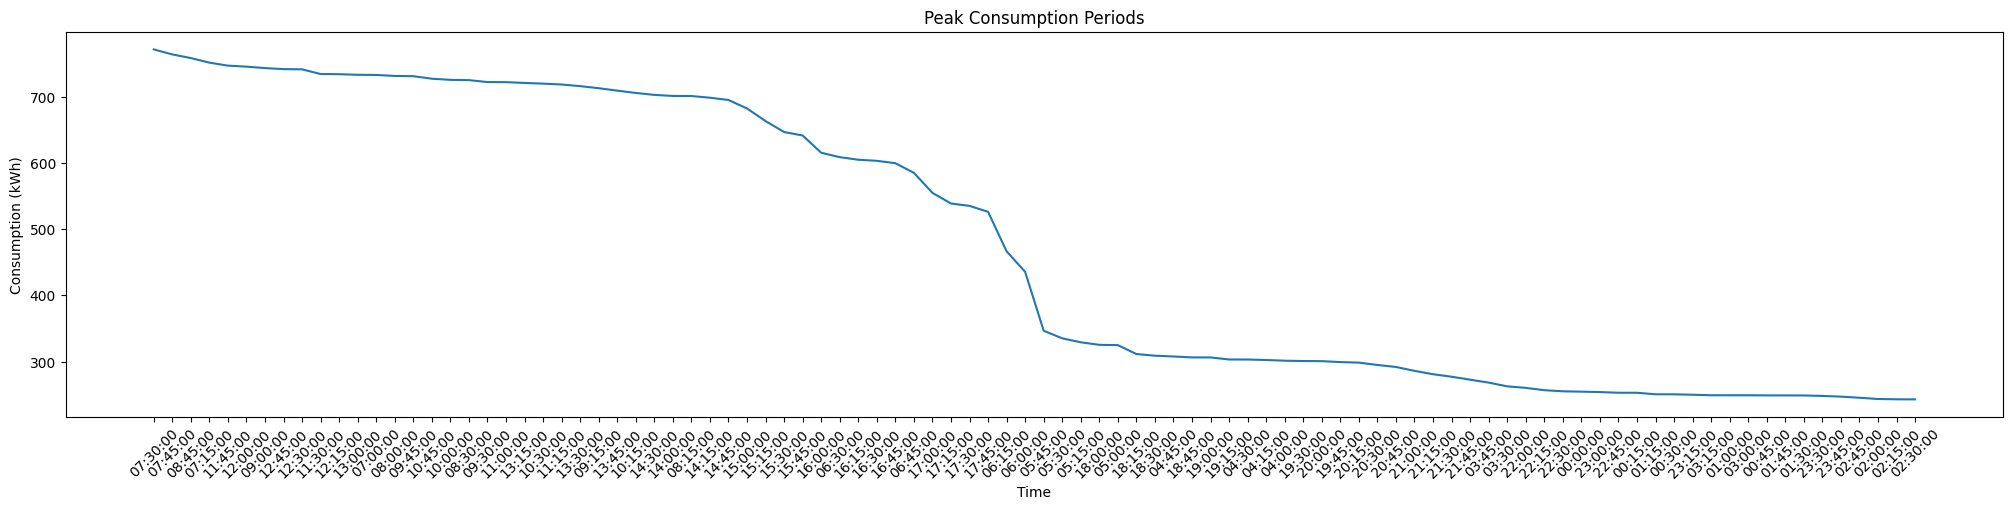

In [ ]:
import matplotlib.pyplot as plt

# Convert datetime to string
peak_consumption_periods.index = peak_consumption_periods.index.astype(str)

# Plot the peak consumption periods
plt.figure(figsize=(25, 5))
plt.plot(peak_consumption_periods.index, peak_consumption_periods.values)
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.title('Peak Consumption Periods')
plt.xticks(rotation=45)
plt.show()




In [ ]:
# Pre-bought rate per kWh
prebought_rate_per_kWh = 2350 / 1000  # converting to kWh price

# Calculate the daily cost under the pre-bought contract
merged_data_corrected['Prebought_Cost'] = merged_data_corrected['Consumption_kWh'] * prebought_rate_per_kWh

# Calculate the daily cost under the spot market
merged_data_corrected['Daily_Cost'] = merged_data_corrected['Consumption_kWh'] * merged_data_corrected['Daily_Average_Price'] / 1000  # converting to kWh price

# Identify the days when it is cheaper to buy on the spot market
merged_data_corrected['Spot_Cheaper'] = merged_data_corrected['Daily_Cost'] < merged_data_corrected['Prebought_Cost']

# Display the first few rows of the corrected merged data with daily cost
merged_data_corrected.head(10)

# Save the merged data with daily cost to a new CSV file    
merged_data_corrected.to_csv('merged_data_corrected.csv', index=False)

#save the consumption data to a new CSV file
consumption_data.to_csv('consumption_data.csv', index=False)

# calculate the total consumption if kWh
total_consumption_kWh = consumption_data['Consumption_kWh'].sum()

total_consumption_kWh


7811580

In [ ]:
# Calculate the total cost for the entire period
total_cost_spot_market_full_period = merged_data_corrected['Daily_Cost'].sum()
total_cost_prebought_full_period = merged_data_corrected['Prebought_Cost'].sum()

# Calculate the potential savings
potential_savings = total_cost_prebought_full_period - total_cost_spot_market_full_period

# Prepare the results
cost_savings_analysis = {
    'Total Cost for Pre-bought Contract': total_cost_prebought_full_period,
    'Total Cost for Spot Market': total_cost_spot_market_full_period,
    'Potential Savings (Pre-bought - Spot Market)': potential_savings
}

cost_savings_df = pd.DataFrame([cost_savings_analysis])
cost_savings_df

#save the cost savings analysis to a new CSV file
cost_savings_df.to_csv('cost_savings_analysis.csv', index=False)


In [ ]:
import plotly.graph_objects as go

# Create a Plotly graph to show the relevant information
fig = go.Figure()

# Add traces for Spot Market Cost and Pre-bought Contract Cost
fig.add_trace(go.Scatter(x=merged_data_corrected['Date'], y=merged_data_corrected['Daily_Cost'], mode='lines', name='Spot Market Cost', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=merged_data_corrected['Date'], y=merged_data_corrected['Prebought_Cost'], mode='lines', name='Pre-bought Contract Cost', line=dict(color='red', dash='dash')))

# Highlight the days where the spot market is cheaper
fig.add_trace(go.Scatter(x=merged_data_corrected['Date'][merged_data_corrected['Spot_Cheaper']], 
                         y=merged_data_corrected['Daily_Cost'][merged_data_corrected['Spot_Cheaper']], 
                         mode='markers', name='Spot Market Cheaper', marker=dict(color='green', size=5)))

# Update layout for better visualization
fig.update_layout(
    title='Comparison of Daily Electricity Costs: Spot Market vs. Pre-bought Contract',
    xaxis_title='Date',
    yaxis_title='Cost (Currency)',
    legend_title='Legend',
    template='plotly_white'
)

# Show the plot
fig.show()
fig.write_html("comparison.html")


In [ ]:
# Extract daily data for May 2024
may_2024_data = merged_data_corrected[(merged_data_corrected['Date'] >= '2024-05-01') & (merged_data_corrected['Date'] < '2024-06-01')]

# Display the daily data for May 2024
may_2024_data[['Date', 'Consumption_kWh', 'Daily_Average_Price', 'Prebought_Cost', 'Daily_Cost']]

##calcualte the total consumption 


,Date,Consumption_kWh,Daily_Average_Price,Prebought_Cost,Daily_Cost
1947,2024-05-01,24872,154.00,58449.20,3830.28800
1948,2024-05-02,52097,967.00,122427.95,50377.79900
1949,2024-05-03,48883,1984.90,114875.05,97027.86670
1950,2024-05-04,22829,1827.62,53648.15,41722.73698
1951,2024-05-05,22743,1337.56,53446.05,30420.12708
...,...,...,...,...,...
2295,2024-05-31,48640,NaN,114304.00,NaN
2296,2024-05-31,48640,NaN,114304.00,NaN
2297,2024-05-31,48640,NaN,114304.00,NaN
2298,2024-05-31,48640,NaN,114304.00,NaN


In [ ]:
# Remove duplicate entries by keeping the first occurrence
may_2024_data_cleaned = may_2024_data.drop_duplicates(subset=['Date'], keep='first')

# Recalculate the monthly costs for May 2024
corrected_may_2024_costs = may_2024_data_cleaned[['Prebought_Cost', 'Daily_Cost']].sum()

# Update the monthly costs dataframe
monthly_costs.loc[monthly_costs['Month'] == '2024-05', ['Total_Spot_Market_Cost', 'Total_Prebought_Cost']] = corrected_may_2024_costs.values

# Display the updated monthly costs dataframe
monthly_costs

#save the montly costs to a new CSV file
monthly_costs.to_csv('monthly_costs.csv', index=False)

#


In [ ]:
# Load the spot price data from the provided CSV file with the correct separator
energy_data = pd.read_csv(spot_price_file_path, sep=',')

# Rename columns for easier handling
energy_data.columns = ['Date', 'Daily_Average_Price', 'Hourly_Price']

# Convert the Date column to datetime
energy_data['Date'] = pd.to_datetime(energy_data['Date'], format='%a %b %d %Y', errors='coerce')

# Filter the data to keep only entries from the year 2021 and newer
energy_data_filtered = energy_data[energy_data['Date'].dt.year >= 2021]

# Display the first few rows of the prepared data
energy_data_filtered.head()

# Save the cleaned data to a new CSV file
prepared_spot_price_file_path_filtered = 'prepared_hodinove-denni_filtered.csv'
energy_data_filtered.to_csv(prepared_spot_price_file_path_filtered, index=False)

prepared_spot_price_file_path_filtered


'prepared_hodinove-denni_filtered.csv'

## Ceník přirážky

PREBOUGHT 8,4 Euro /MWh
SPOT 5,3 e/MWH

# VISUALIZE THE DATA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Load the CSV file
file_path = 'peak_consumption_periods.csv'
data = pd.read_csv(file_path)


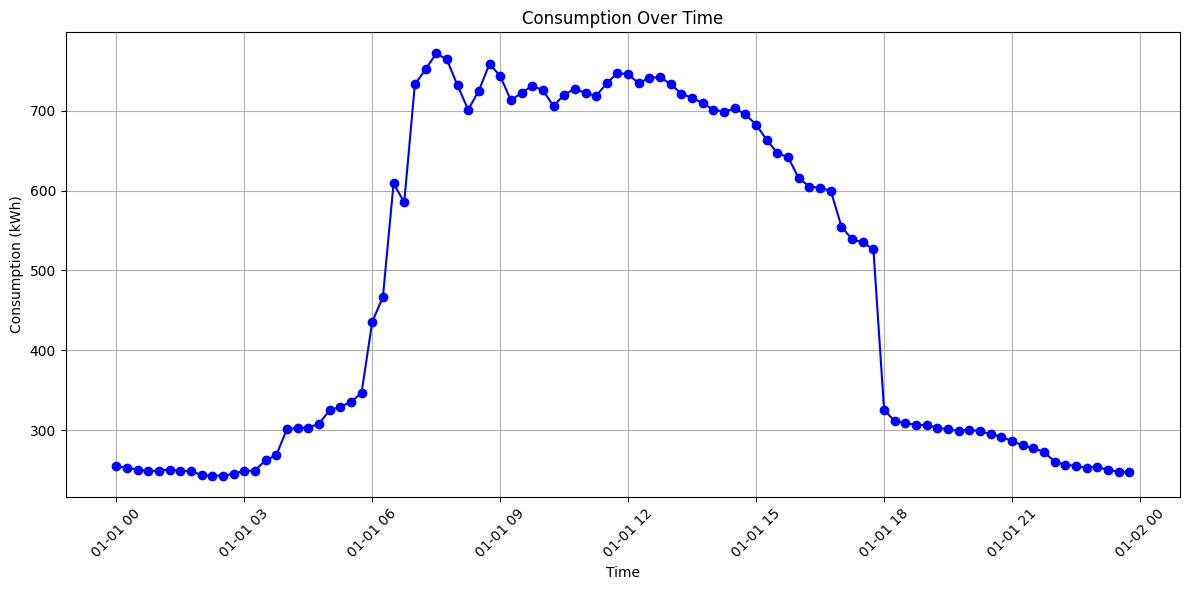

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

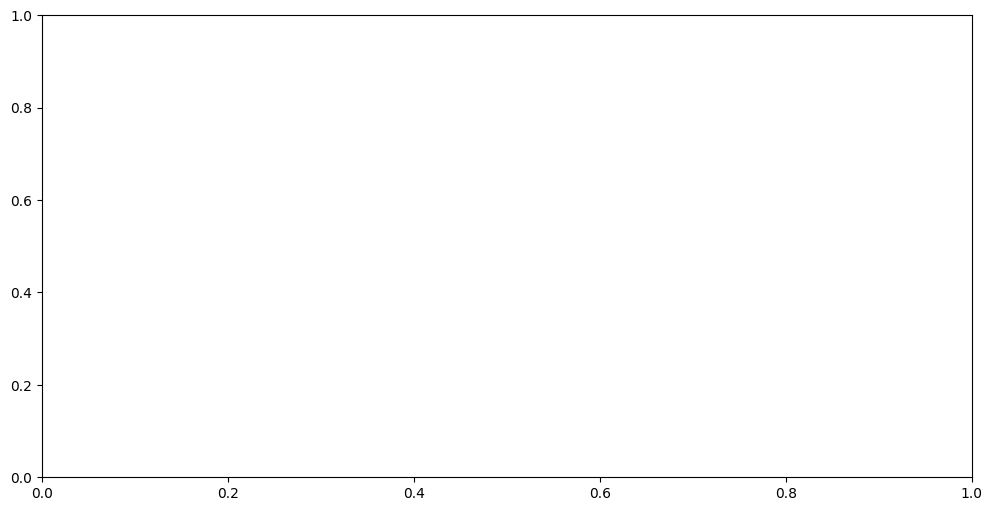

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'Time' column to datetime for better plotting
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S')

# Sort data by Time for better visualization
data.sort_values('Time', inplace=True)

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Consumption_kWh'], marker='o', linestyle='-', color='b')
plt.title('Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar Plot
plt.figure(figsize=(12, 6))
plt.bar(data['Time'].dt.time, data['Consumption_kWh'], color='skyblue')
plt.title('Consumption at Different Times')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Heatmap Preparation
# Extract hour and minute for a more detailed heatmap
data['Hour'] = data['Time'].dt.hour
data['Minute'] = data['Time'].dt.minute

# Pivot table for heatmap
heatmap_data = data.pivot_table(index='Hour', columns='Minute', values='Consumption_kWh')

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f")
plt.title('Heatmap of Consumption Over Time')
plt.xlabel('Minute')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()


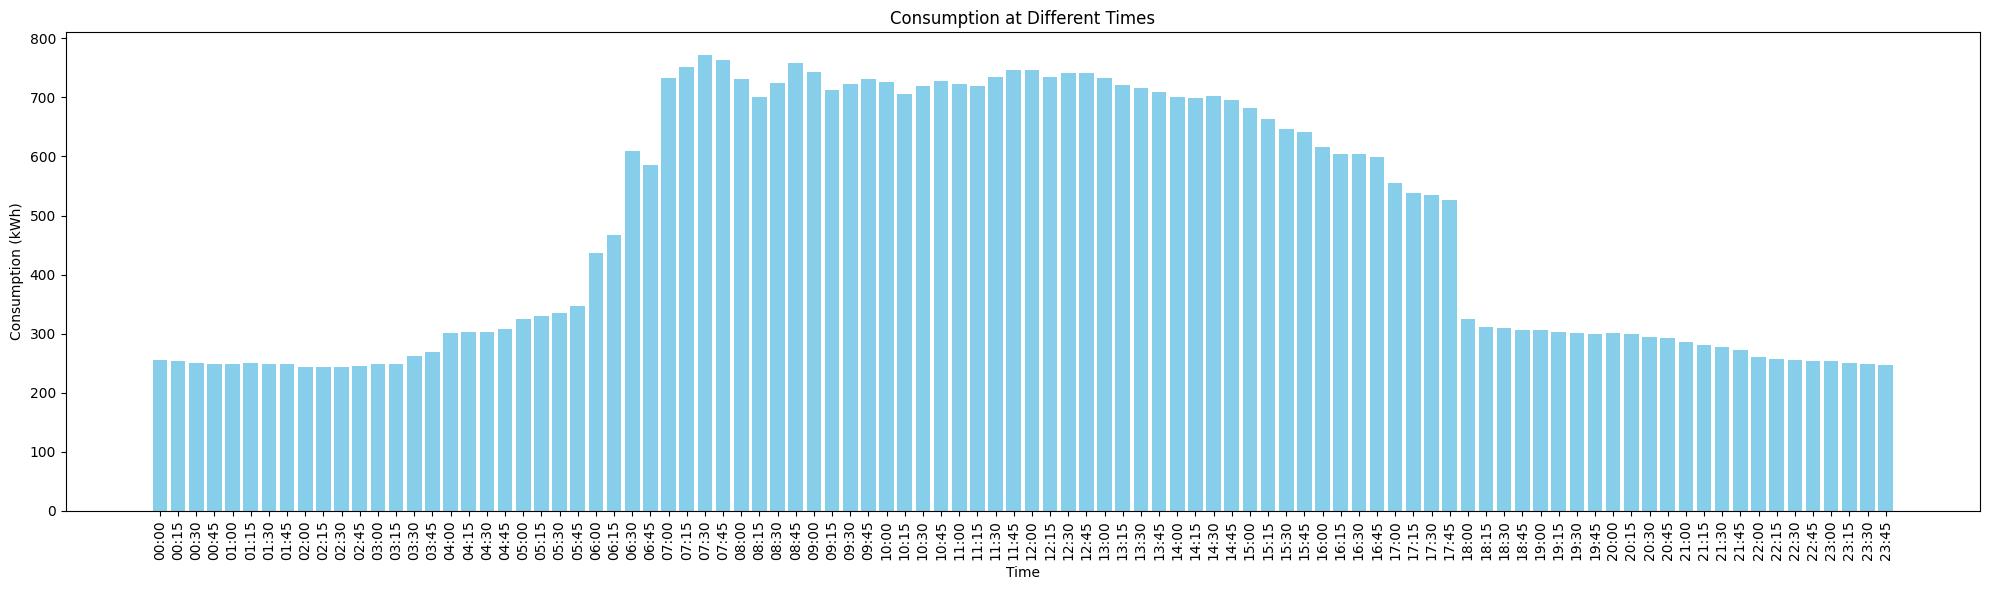

In [ ]:
# Convert 'Time' to string format for bar plot
data['Time_str'] = data['Time'].dt.strftime('%H:%M')

# Bar Plot
plt.figure(figsize=(20, 6))
plt.bar(data['Time_str'], data['Consumption_kWh'], color='skyblue')
plt.title('Consumption at Different Times')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


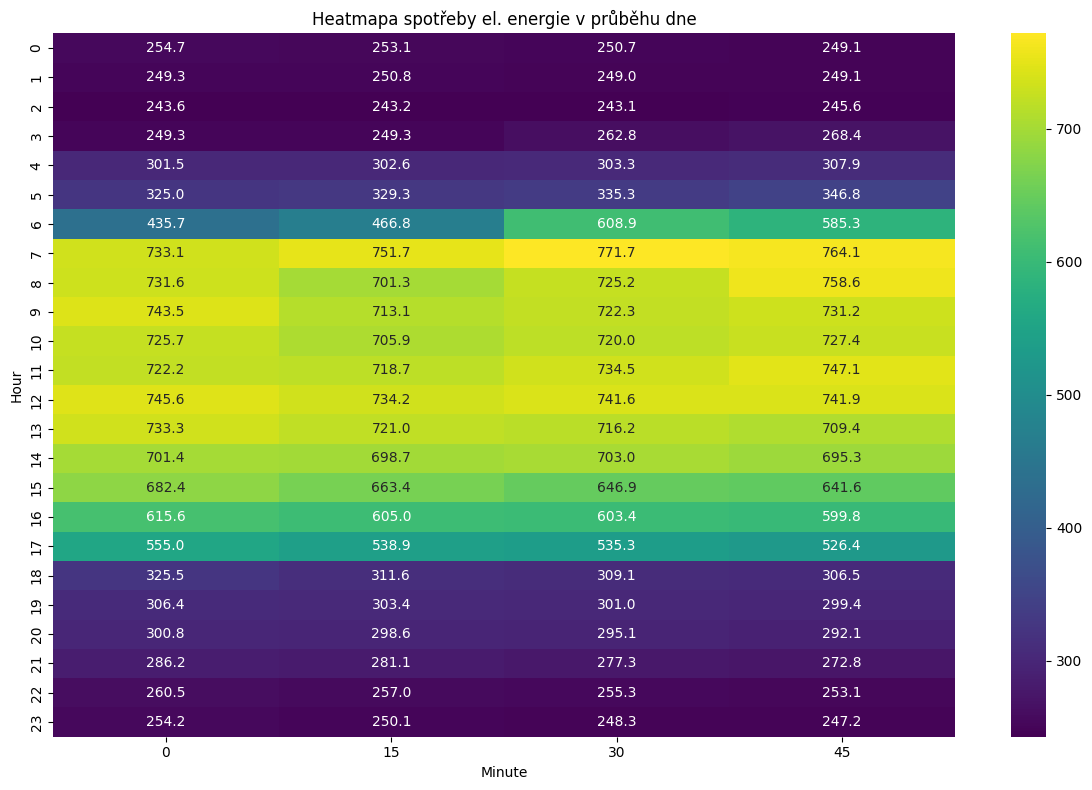

In [ ]:
data['Hour'] = data['Time'].dt.hour
data['Minute'] = data['Time'].dt.minute
heatmap_data = data.pivot_table(index='Hour', columns='Minute', values='Consumption_kWh')

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f")
plt.title('Heatmapa spotřeby el. energie v průběhu dne')
plt.xlabel('Minute')
plt.ylabel('Hour')
plt.tight_layout()
plt.show()

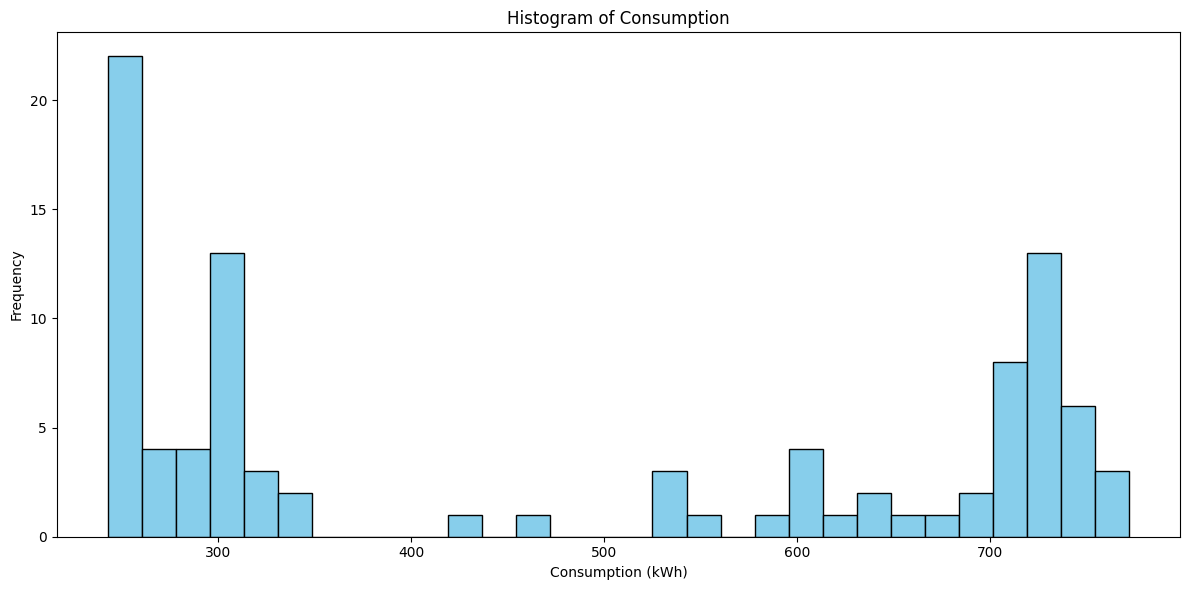

In [ ]:
# Histogram
plt.figure(figsize=(12, 6))
plt.hist(data['Consumption_kWh'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Consumption')
plt.xlabel('Consumption (kWh)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


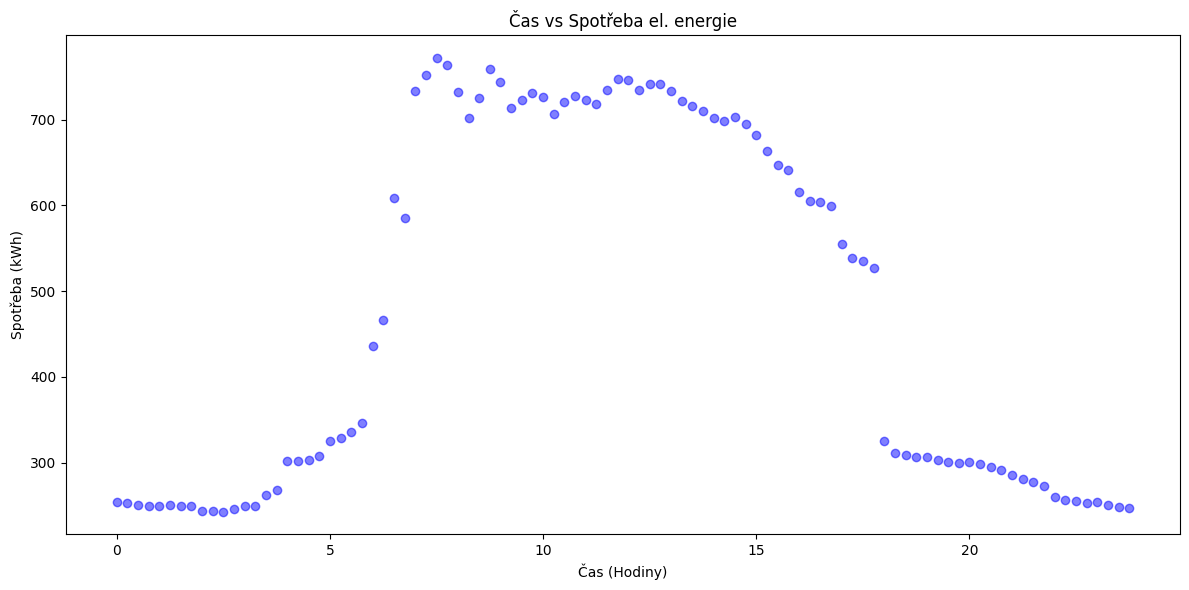

In [ ]:
# Scatter Plot
plt.figure(figsize=(12, 6))
plt.scatter(data['Time'].dt.hour + data['Time'].dt.minute / 60, data['Consumption_kWh'], color='blue', alpha=0.5)
plt.title('Čas vs Spotřeba el. energie')
plt.xlabel('Čas (Hodiny)')
plt.ylabel('Spotřeba (kWh)')
plt.tight_layout()
plt.show()
